In [26]:
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
from torchvision import transforms

torch.set_default_dtype(torch.float32)

In [27]:
batch_size = 100

device = ("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [29]:
mnist = torchvision.datasets.MNIST(root="datasets/",
                                  train=True,
                                  transform=transform,
                                  download=True)

In [30]:
data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                         batch_size=batch_size,
                                         shuffle=True)

In [31]:
images, labels = iter(data_loader).next()

In [32]:
img = torchvision.utils.make_grid(images)

In [33]:
img = img.detach().numpy()
img = img.clip(0, 1)

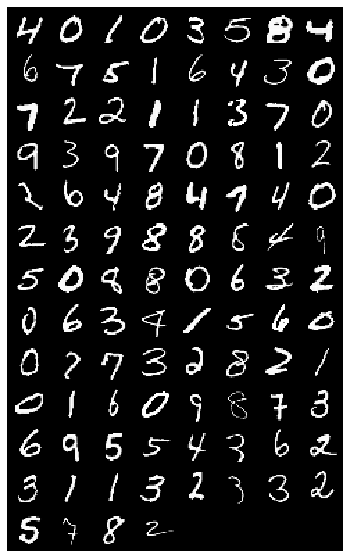

In [34]:
plt.figure(figsize=(12,10))
plt.imshow(img.transpose(1,2,0))
plt.axis("off")
plt.show()

In [35]:
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 100

In [36]:
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Dropout(0.5),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Dropout(0.5),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()
)

In [37]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh()
)

In [38]:
D = D.to(device)
G = G.to(device)

In [39]:
bce_loss = nn.BCELoss()

d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [40]:
total_step = len(data_loader)

In [43]:
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)
        
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.ones(batch_size, 1).to(device)
        
        outputs = D(images)
        
        d_loss_real = bce_loss(outputs, real_labels)
        real_score = outputs
        
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        
        outputs = D(fake_images)
        
        d_loss_fake = bce_loss(outputs, fake_labels)
        fake_score = outputs
        
        d_loss = d_loss_real + d_loss_fake
        
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        
        d_loss.backward()
        d_optimizer.step()
        
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        
        outputs = D(fake_images)
        
        g_loss = bce_loss(outputs, real_labels)
        
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        
        g_loss.backward()
        g_optimizer.step()
        
        if (i+1)%200==0:
            print("Epoch [{}/{}], Step [{}/{}], d_loss: {:.6f}, g_loss: {:.6f}, D(x): {:.2f}, D(G(x)): {:.2f}"
                 .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                        real_score.mean().item(), fake_score.mean().item()))
            
        fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)         
        

Epoch [0/100], Step [200/600], d_loss: 0.000010, g_loss: 0.000005, D(x): 1.00, D(G(x)): 1.00
Epoch [0/100], Step [400/600], d_loss: 0.000015, g_loss: 0.000010, D(x): 1.00, D(G(x)): 1.00
Epoch [0/100], Step [600/600], d_loss: 0.000005, g_loss: 0.000002, D(x): 1.00, D(G(x)): 1.00
Epoch [1/100], Step [200/600], d_loss: 0.000007, g_loss: 0.000003, D(x): 1.00, D(G(x)): 1.00


KeyboardInterrupt: 

In [ ]:
img = torchvision.utils.make_grid(fake_images)

In [ ]:
img = img.detach().numpy()
img = img.clip(0, 1)

In [ ]:
plt.figure(figsize=(12,10))
plt.imshow(img.transpose(1,2,0))
plt.axis("off")
plt.show()